<a href="https://colab.research.google.com/github/onism/MyLearning/blob/master/ResNet_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, add 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import  Model  
from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.utils import plot_model, to_categorical
import numpy as np 
import os 
import math

In [2]:
batch_size = 32
epochs = 10
data_augmentation = True  
num_classes = 10 
subtract_pixel_mean = True 

n = 3 
version = 1 # ResNet v1 and ResNet V2 
if version == 1:
    depth = n * 6 + 2 
else:
    depth = n * 9 + 2

model_type = 'ResNet%dv%d'%(depth, version)

In [3]:
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean 
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [18]:
def lr_schedule(epoch):
    lr = 1e-3 
    if epoch > 180:
        lr *= 0.5e-3 
    elif epoch > 160:
        lr *= 1e-3 
    elif epoch > 120:
        lr *= 1e-2 
    elif epoch > 80:
        lr *= 1e-1 
    return lr 

ResLayer

v1: x -> conv(x) 
v2  x -> BN->conv(x)

In [5]:
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
    conv = Conv2D(num_filters, 
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_regularizer=l2(1e-4),
                  kernel_initializer = 'he_normal'
                  )
    x = inputs 
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x
    


In [14]:
def resnet_v1(input_shape, depth, num_classes=10):
    num_filters = 16
    num_res_blocks = int( (depth-2)/6 )
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs)

    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1 
            if stack >0 and res_block == 0:
                strides = 2 
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack >0 and  res_block == 0:
                x = resnet_layer(inputs = x, num_filters=num_filters, kernel_size=1, strides=strides, activation=None, batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
    
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(y)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
def resnet_v2(input_shape, depth, num_classes=10):
    '''
       (1 x 1)-(3 x 3)-(1 x 1)  BN-ReLU-Conv2D 
       conv1  : 32x32,  16
      stage 0: 32x32,  64
      stage 1: 16x16, 128
      stage 2:  8x8,  256
    '''
    num_filters_in = 16
    num_res_blocks = int( (depth - 2)/9)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs, num_filters=num_filters_in, conv_first=True)
    for stage in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            activation = 'relu' 
            batch_normalization = True
            if stage == 0:
                num_filters_out = num_filters_in * 4 
                if res_block == 0:
                    activation = None 
                    batch_normalization = False 
            else:
                num_filters_out = num_filters_in * 2 
                if res_block == 0:
                    strides = 2 
            
            y = resnet_layer(inputs=x, num_filters=num_filters_in, kernel_size=1, strides=strides, activation=activation, batch_normalization=batch_normalization, conv_first=False)
            y = resnet_layer(inputs=y, num_filters=num_filters_in, conv_first=False)
            y = resnet_layer(inputs=y, num_filters=num_filters_out, kernel_size=1, conv_first=False)
            if res_block == 0:
                x = resnet_layer(inputs=x, num_filters=num_filters_out, kernel_size=1, strides=strides, activation=None, batch_normalization=False)
            x = add([x, y])
        num_filters_in = num_filters_out

    # v2 has BN-ReLU before pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D()(x)
    y = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(y)
    model = Model(inputs=inputs, outputs=outputs)
    return model


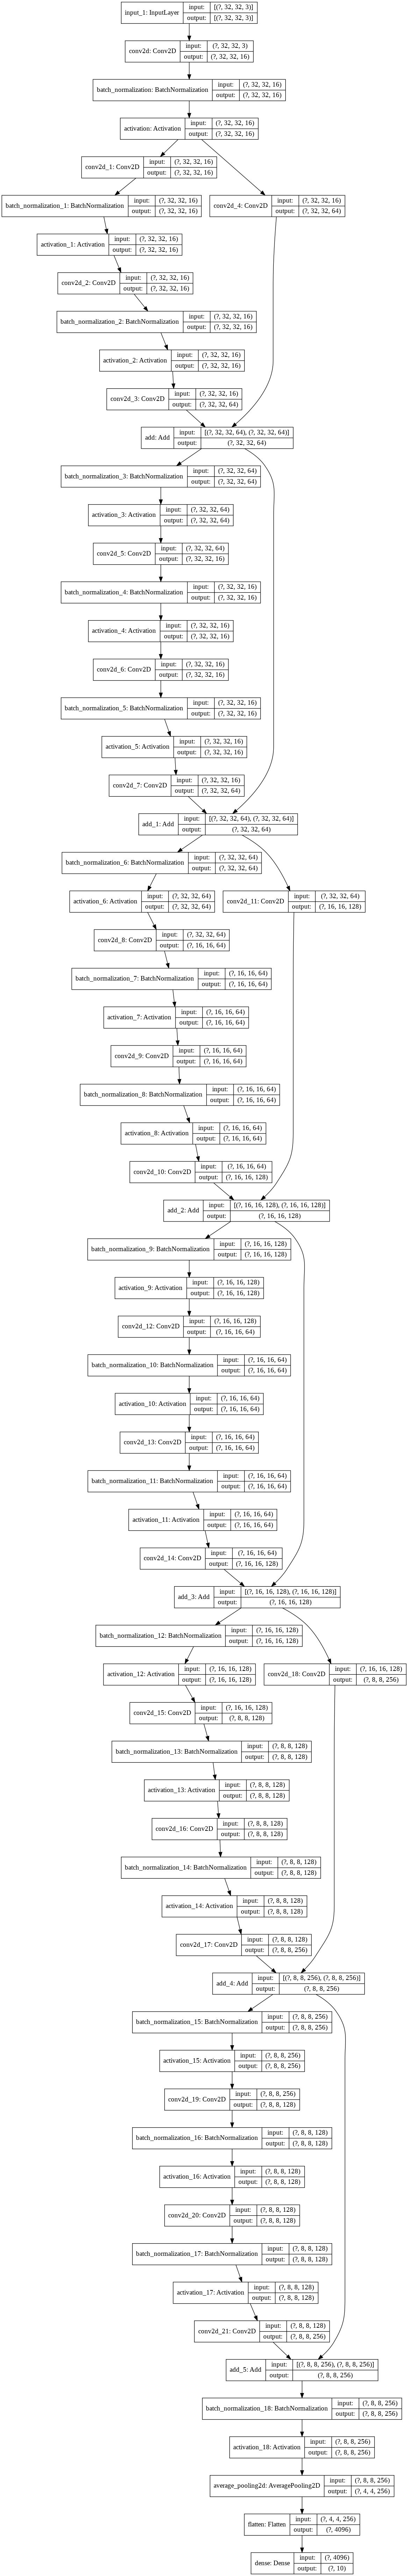

In [12]:
model = resnet_v2(input_shape=input_shape, depth=depth)
plot_model(model, to_file="%s.png" % model_type, show_shapes=True)


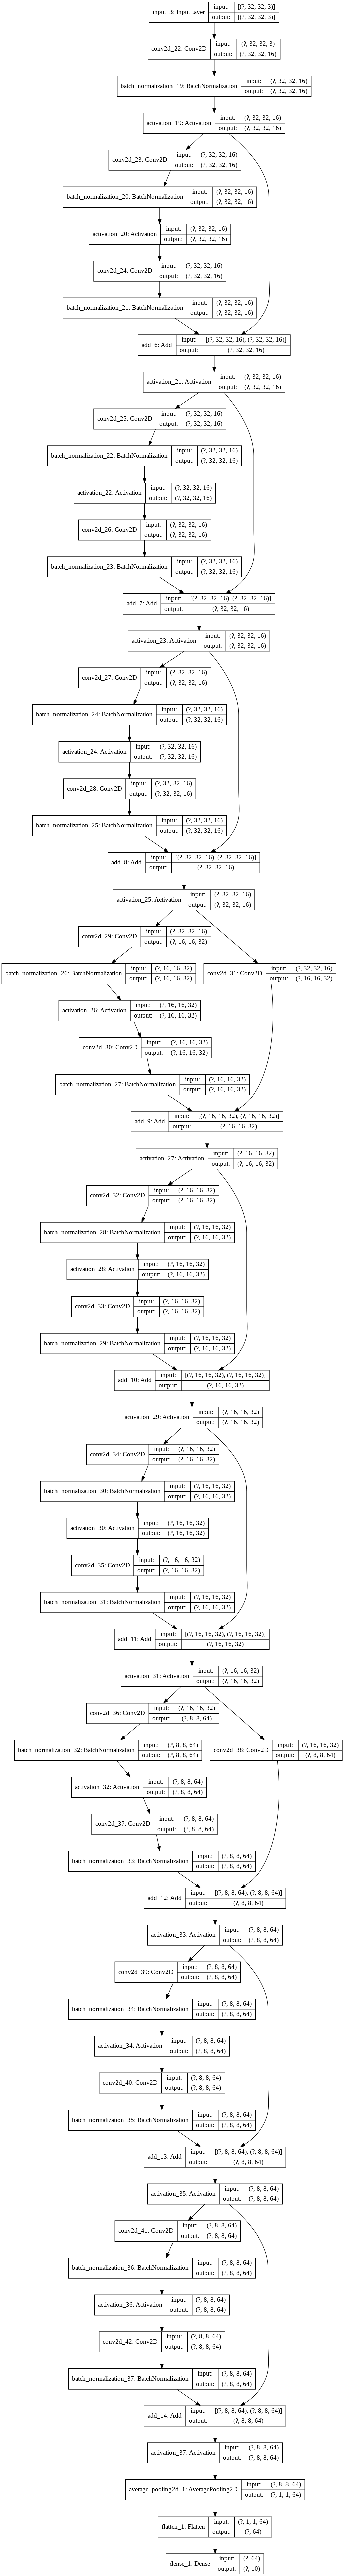

In [15]:
model = resnet_v1(input_shape=input_shape, depth=depth)
plot_model(model, to_file="%s.png" % model_type, show_shapes=True)


In [19]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr_schedule(0)), metrics='acc'  )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 16)   64          conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 32, 32, 16)   0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [20]:
# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

 #prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [21]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Epoch 1/10
 597/1563 [==========>...................] - ETA: 7:00 - loss: 1.7584 - acc: 0.4199

KeyboardInterrupt: ignored

In [ ]:
# use data augmentation

datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)
datagen.fit(x_train)
steps_per_epoch = math.ceil( len(x_train)/batch_size )
model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size), 
          verbose=1, epochs=epochs, validation_data=(x_test, y_test), 
          steps_per_epoch=steps_per_epoch, callbacks=callbacks)
 

Epoch 1/10
  71/1563 [>.............................] - ETA: 10:55 - loss: 1.5647 - acc: 0.5009